# Variational Monte Carlo with Neural Networks

In this tutorial we will use the NetKet software package to find the ground state of the J1-J2 model in one-dimension with periodic boundary condition. The Hamiltonian of the model is given by:

$$ H = \sum_{i=1}^{L} J_{1}\hat{S}_{i} \cdot \hat{S}_{i+1} + J_{2} \hat{S}_{i} \cdot \hat{S}_{i+2} $$

where the sum is over sites of the 1-D chain.


We will also explore some useful functionalities provided by the package.

## Objectives:
    1. Defining custom Hamiltonians
    2. Defining the machine (variational ansatz)
    3. Variational Monte Carlo Optimisation
    4. Measuring observables
    5. Data Visualisation
    6. Sanity Check: Exact Diagonalisation
    
Let's start.

In [1]:
# Import netket library
import netket as nk
from mpi4py import MPI

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

## 1) Defining a Custom Hamiltonian

The first thing to do is to define the graph (lattice) on which to specify the Hamiltonian. Here we would like to build a one-dimensional graph with both nearest and next nearest neighbour bonds. The graph is created in the ``nk.graph.CustomGraph`` class. To initialise the class we simply provide a list of edges in the ``[[site_i, site_j, edge_color], ...]``

In [2]:
#Couplings J1 and J2
J = [1, 0.2]
L = 16

In [3]:
# Define custom graph
edge_colors = []
for i in range(L):
    edge_colors.append([i, (i+1)%L, 1])
    edge_colors.append([i, (i+2)%L, 2])

# Define the netket graph object
g = nk.graph.CustomGraph(edge_colors)

We specify a different ``color`` for each type of bond so as to define the a different operator for each of them.

Next, we define the relevant bond operators. 

In [4]:
#Sigma^z*Sigma^z interactions
sigmaz = [[1, 0], [0, -1]]
mszsz = (np.kron(sigmaz, sigmaz))

#Exchange interactions
exchange = np.asarray([[0, 0, 0, 0], [0, 0, 2, 0], [0, 2, 0, 0], [0, 0, 0, 0]])

bond_operator = [
    (J[0] * mszsz).tolist(),
    (J[1] * mszsz).tolist(),
    (-J[0] * exchange).tolist(),  
    (J[1] * exchange).tolist(),
]

bond_color = [1, 2, 1, 2]

Notice the minus sign in front of the exchange. This is simply a basis rotation corresponndign to the Marshall sign rule to help alleviate the sign problem. The model is still not completely sign problem free due to the next nearest neighbour coupling.

Before defining the Hamiltonian, we also need to specify the Hilbert space. For our case, this would be the chain spin-half degrees of freedom.

In [5]:
# Spin based Hilbert Space
hi = nk.hilbert.Spin(s=0.5, total_sz=0.0, graph=g)

Now we can define the custom graph Hamiltonian using the ``nk.operator.GraphOperator`` class, by providing the hilbert space ``hi``, the bond operators ``bondops=bond_operator`` and the corresponding bond color ``bondops_colors=bond_color``. The information about the graph (bonds and bond colors) are contained within the ``nk.hilbert.Spin`` object ``hi``.

In [6]:
# Custom Hamiltonian operator
op = nk.operator.GraphOperator(hi, bondops=bond_operator, bondops_colors=bond_color)

## 2) Defining the Machine

For this tutorial, we shall use the most common type of neural network: fully connected feedforward neural network ``nk.machine.FFNN``. 

In [7]:
# Define the fully-connected FFNN
layers = (nk.layer.FullyConnected(input_size=L,output_size=2*L,use_bias=True),
          nk.layer.Lncosh(input_size=2*L),
          nk.layer.SumOutput(input_size=2*L))
for layer in layers:
    layer.init_random_parameters(seed=1234, sigma=0.01)
    
ffnn = nk.machine.FFNN(hi, layers)

## 3) Variational Monte Carlo Optimisation

We have now setup our model (Hamiltonian, Graph, Hilbert Space) and can proceed to optimise the variational ansatz we chose namely the ``ffnn`` machine.

To setup the variational Monte Carlo optimisation tool, we have to provide a sampler ``nk.sampler`` and an optimizer ``nk.optimizer``.

In [8]:
# We shall use an exchange Sampler which preserves the global magnnetization
sa = nk.sampler.MetropolisExchange(graph=g, machine=ffnn, d_max = 2)

# We choose most base Optimizer namely stochastic gradient descent
opt = nk.optimizer.Sgd(learning_rate=0.01)

# We can then specify VMC object one for the rbm and one for the ffnn
gs = nk.variational.Vmc(hamiltonian=op,
                        sampler=sa,
                        optimizer=opt,
                        n_samples=1000,
                        use_iterative=True,
                        method='Sr')

## 4) Measuring Observables

Before running the optimization, it can be helpful to add some observables to keep track off during the optimization, e.g. staggered magnetization. For our purpose, let us measure the Neel order defined by

$$ \frac{1}{L(L+2)} \sum_{ij} \langle \hat{S}_{i} \cdot \hat{S}_{j}\rangle e^{i\pi(i-j)}$$.

In [9]:
# We need specify the local operators as a matrix acting on a local Hilbert space 
neel = []
sites = []
for i in range(0, L):
    for j in range(0, L):
        neel.append((((-1)**(i-j))*(mszsz+((-1)**(i+j))*exchange)).tolist())
        sites.append([i,j])
neel_order = nk.operator.LocalOperator(hi, neel, sites)

# Add the observable to the VMC object
gs.add_observable(neel_order, "neel")

Once again, notice that we had to multiply the exchange operator (matrix) by some factor. This is to account for the Marshall basis rotation we made in our model.

We can now optimize our variational ansatz. The optimization data for each iteration would be stored in a log file. 
In each iteration, the following innformation is saved inn the specified log file:
1. Mean, variance and uncertainty in the Energy $ \langle \hat{H} \rangle $
2. Mean, variance and uncertainty in the Energy Variance, $ \langle\hat{H}^{2}\rangle-\langle \hat{H}\rangle^{2}$.
3. Acceptance rates of the sampler
4. Mean, variance and uncertainty of observables (if specified)

In [10]:
# Run the optimization protocol
gs.run(output_prefix='test', n_iter=400)

## 5) Data Visualisation

Now that we have optimized our machine to find the ground state of the J1-J2 model, let's look at what we have.
The relevant data are stored in the ".log" file while the optimized parameters are inn the ".wf" file. The files are all in json format.

We shall extract the energy as well our specified observable (Neel order for our case) from the ".log" file.

In [11]:
# Load the data from the .log file
import json

data=json.load(open("test.log"))

# Extract the relevant information

iters=[]
energy=[]
neel=[]

for iteration in data["Output"]:
    iters.append(iteration["Iteration"])
    energy.append(iteration["Energy"]["Mean"])
    neel.append(iteration["neel"]["Mean"])

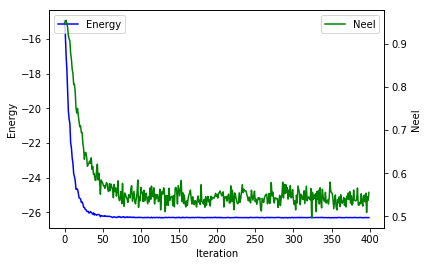

In [12]:
fig, ax1 = plt.subplots()
ax1.plot(iters, energy, color='blue', label='Energy')
ax1.set_ylabel('Energy')
ax1.set_xlabel('Iteration')
ax2 = ax1.twinx() 
ax2.plot(iters, np.array(neel)/(L*(L+2)), color='green', label='Neel')
ax2.set_ylabel('Neel')
ax1.legend(loc=2)
ax2.legend(loc=1)
plt.show()

Let's also compute the average of those quantities (energy and neel order) over the last 50 iterations where the optimization seems to have connverged.

In [13]:
print(r"Neel order = {0:.3f}({1:.3f})".format(np.mean(neel[-50:])/(L*(L+2)),
                                              np.std(np.array(neel[-50:])/(L*(L+2)))/np.sqrt(50)))
print(r"Energy = {0:.3f}({1:.3f})".format(np.mean(energy[-50:]), np.std(energy[-50:])/(np.sqrt(50))))

Neel order = 0.538(0.002)
Energy = -26.304(0.001)


## 6) Sanity Check: Exact Diagonalisation

Now that we have obtained some results using VMC, it is a good time to check the quality of our results (at least for small system sizes). For this purpose, the ``netket`` library provides exact diagonalisation tools.

In [14]:
res = nk.exact.lanczos_ed(op, first_n=1, compute_eigenvectors=True)

In [15]:
print("g.s. neel order: {0:.3f}".format(np.real(res.mean(neel_order, 0))/(L*(L+2))))
print("Exact ground state energy = {0:.3f}".format(res.eigenvalues[0]))

g.s. neel order: 0.544
Exact ground state energy = -26.308


So we see that the both energy and the neel order we obtained is in agreement with the value obtained via exact diagonalisation.